# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Business Objective

The dealers wants to understand and predict the used car prices so that they can list cars for better prices to make profit out of selling the used cars.

### Assess Situation
To help the dealers to predict the prices we need a dataset of the vehicles sold previously. The assumptions are that this dataset will be helpful in predicting the prices as it will have valuable informations to do this task.

### Data Science Goals
The data science team should use the data provided and understand how the data is, build models, train the with the dataset and provide these artifacts to business teams to help them predict prices.

### Project Plan
Here are the stages of the plan
1. Understand the data
2. Prepare the data for modeling
3. Build models
4. Evaluate the models
5. Deploy them so that these can be used by business teams

## Data Understanding

### Initial Data

We have a dataset of [vehicles](data/vehicles.csv) sold from a dealership. Lets load the dataset using pandas.

In [194]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report,r2_score,mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [195]:
cars = pd.read_csv(filepath_or_buffer='./data/vehicles.csv')

### Describe Data
Lets check whats the dataset contains like what features it has and how it can be helpful for model building

In [196]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

This dataset has 17 features(columns) in which 'id' column is not going to be helpful so we can remove this.

It has 426K records.

In [197]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Explore The Data
Lets create some plots to understand the data and the story it tells.

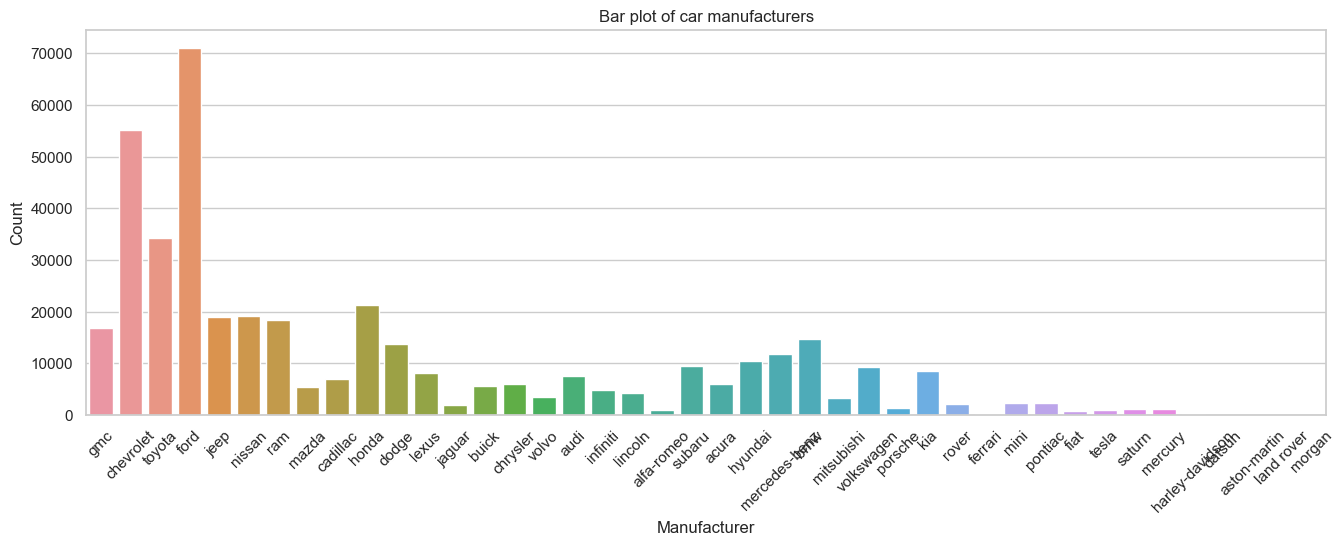

In [198]:
plt.figure(figsize=(16, 5))  # Adjust the width and height as needed
sns.countplot(data=cars, x='manufacturer').set(title='Bar plot of car manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The above plot tells that ford, chevy and toyota cars most sold than any other models.

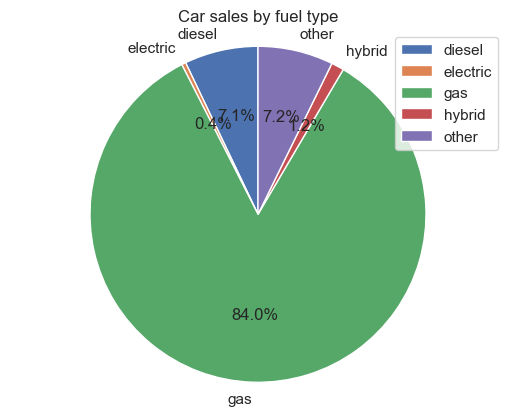

In [199]:
data = cars.groupby('fuel').size()
labels=['diesel','electric', 'gas', 'hybrid', 'other']
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Car sales by fuel type')
plt.legend()
plt.show()


This plot tells that there are many cars sold are gas fueled cars.

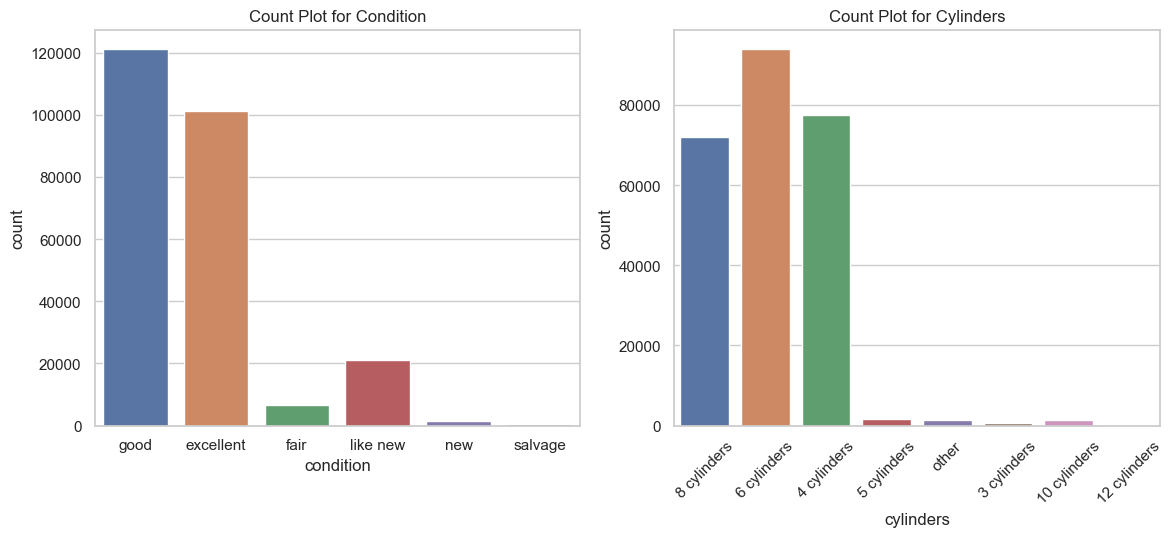

In [200]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='condition', data=cars, ax=axes[0])
axes[0].set_title('Count Plot for Condition')
sns.countplot(x='cylinders', data=cars, ax=axes[1])
axes[1].set_title('Count Plot for Cylinders')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The above plots tells that cars with good and excellent condition and 4 & 6 cylinders vehicles sold which means that if dealers have higher inventory in these categories they might make more sales and more profits.

In [201]:
unique_categories = cars['drive'].unique()
fig = px.pie(cars.dropna(), names='drive', title='Pie Chart of Car Drive Chain')
fig.update_layout(
    legend_title_text='Drive',
    legend_traceorder='reversed',
    legend=dict(title=dict(text='Categories'))
)
fig.show()

It seems like all drive types are sold more or less equally so drive of the car is not going to impact the sales much.

<Figure size 1600x1000 with 0 Axes>

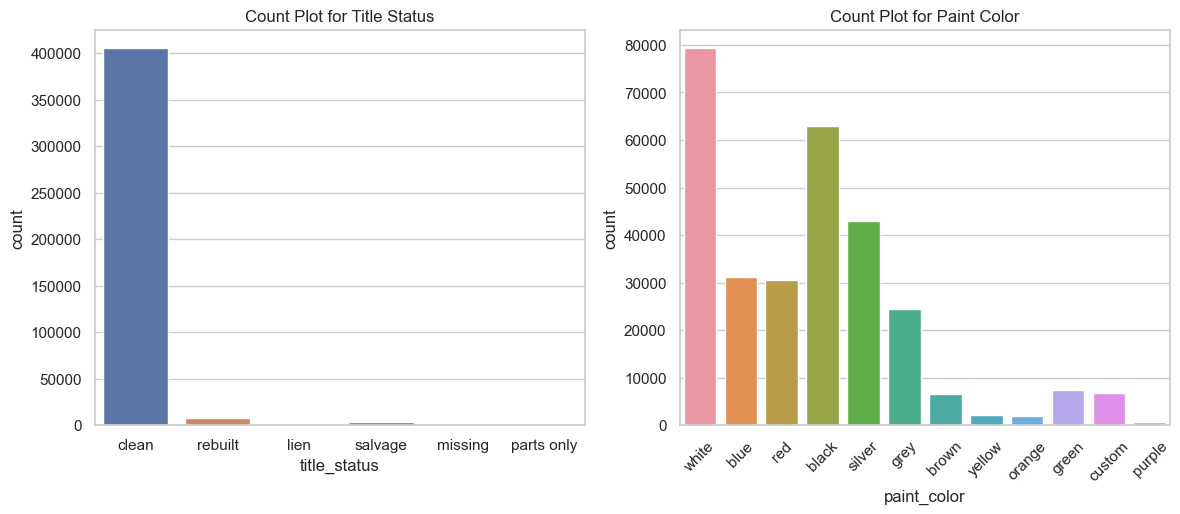

In [202]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='title_status', data=cars, ax=axes[0])
axes[0].set_title('Count Plot for Title Status')
sns.countplot(x='paint_color', data=cars, ax=axes[1])
axes[1].set_title('Count Plot for Paint Color')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

These two plots tells the clean title with white/black/silver colors cars sold more than any other colors so the dealers should look of these colors to stock up for demand.

### Verify Data Quality
Lets evaluate the quality of the data for building models on it.

In [203]:
#dropping id column as this is not going to impact the performance of the model
cars.drop('id', inplace=True,axis=1)

In [204]:
print("Number of duplicates:", len(cars[cars.duplicated()]))

Number of duplicates: 56202


Text(0, 0.5, 'Count')

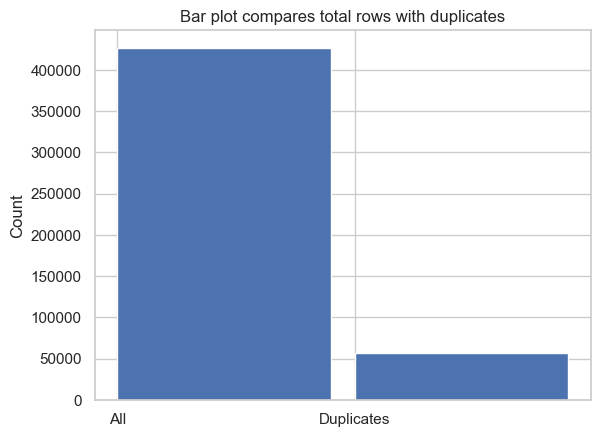

In [205]:
labels = ['All', 'Duplicates']
counts = [len(cars),len(cars[cars.duplicated()])]
plt.bar(labels,counts,width=0.9,align='edge')
plt.title("Bar plot compares total rows with duplicates")
plt.ylabel("Count")


There are 56K rows of duplicates in the dataset which needs to be cleanedup.

In [206]:
cars.isnull().sum()

region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

The above table tells that there are many features that has null values

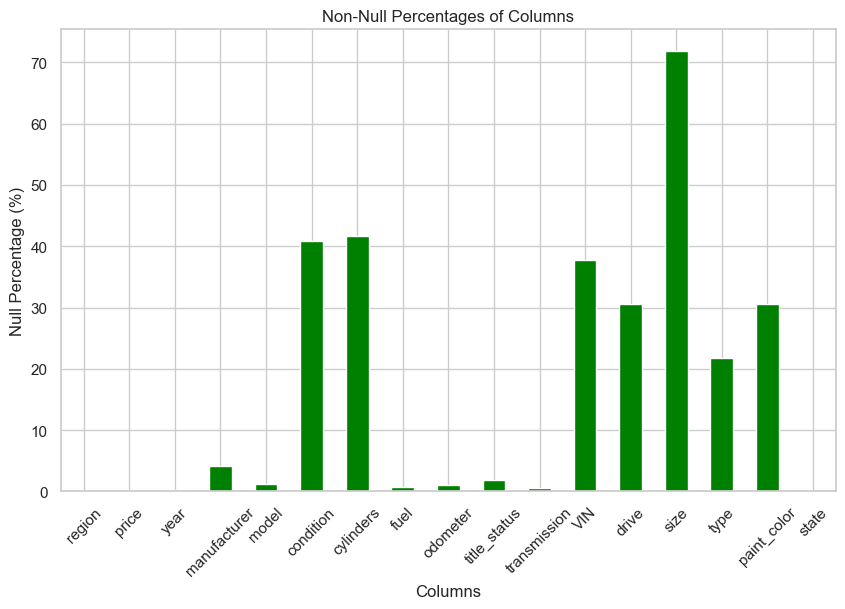

In [207]:
# Calculate the percentage of non-null values for each column
null_percentages = (cars.isnull().mean()) * 100

# Create a bar chart for non-null percentages
null_percentages.plot(kind='bar', rot=0, figsize=(10, 6), color='green')
plt.title('Non-Null Percentages of Columns')
plt.xlabel('Columns')
plt.ylabel('Null Percentage (%)')
plt.xticks(rotation=45)
plt.show()

The above plots tells that size,VIN,drive,cylinders,condition has lot of nulls. It seems this data has lot nulls and needs a lot of data cleanup to make them correct.

array([[<Axes: title={'center': 'price'}>]], dtype=object)

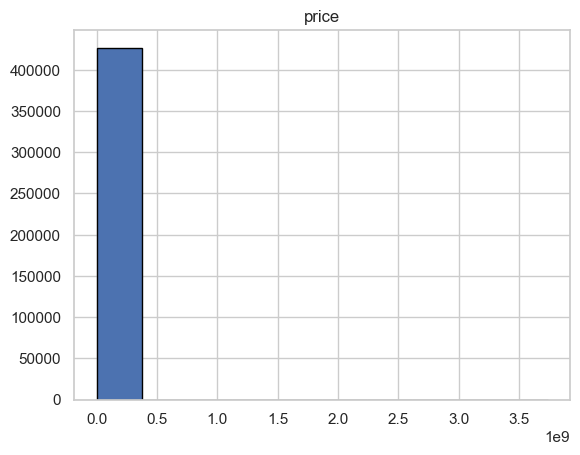

In [208]:
cars.hist(column='price',bins=10, edgecolor='black')


The above histogram on price of the cars is not evernly distributed which may not be helpful in bulding high performance models without any data cleanup. It seems this dataset has some outliers which needs to be removed.

[Text(0.5, 1.0, 'Box Plot of Numerical Columns')]

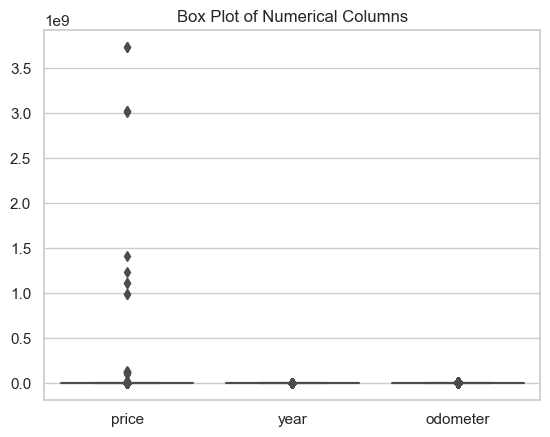

In [209]:
sns.boxplot(data=cars).set(title='Box Plot of Numerical Columns')

This boxplot tells the same that the price of car has some outliers. During the data cleanup phase we will eliminate these outliers which will help improve the model performance.

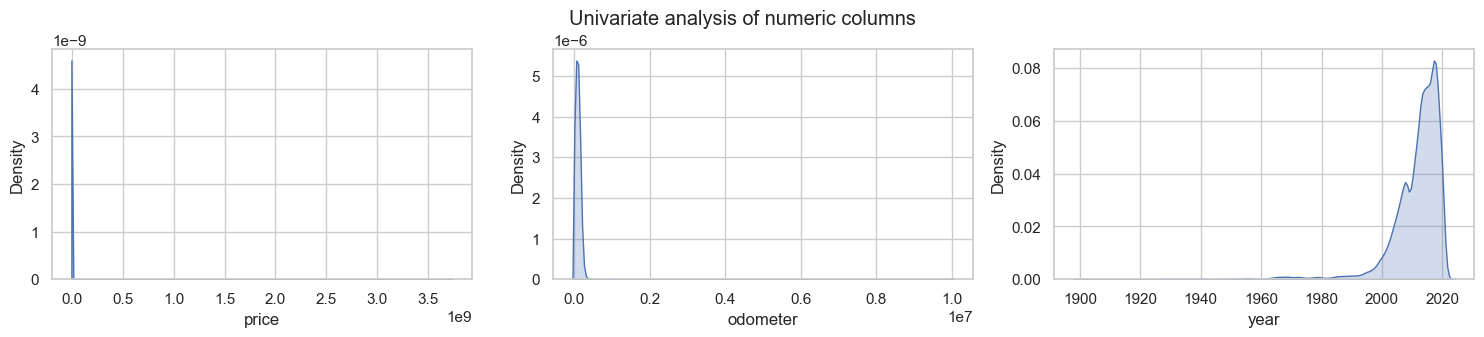

In [210]:
# Univariate analysis of numeric columns
numericCols = ['price', 'odometer', 'year']
plt.figure(figsize=(15, 15))
plt.suptitle("Univariate analysis of numeric columns")
for col in range(len(numericCols)):
    plt.subplot(5,3,col+1)
    sns.kdeplot(x = cars[numericCols[col]], shade=True)
    plt.xlabel(numericCols[col])
    plt.tight_layout()


### Target Feature Analysis
Lets see how the target feature values are and whether it contains any null/zero values which could impact the performance

In [211]:
print('Target Price as 0 (count):',len(cars.query('price == 0')))

Target Price as 0 (count): 32895


There are around 25k rows with 0 as their price which may not add any value in predicting accurate prices of the car. So these can be a candidate for drop.

## Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

***VIN number of a vehicle doesn't help predict the price of the car. Hence, we can get rid of the vin column.***

In [212]:
cars.drop('VIN', inplace = True, axis=1)

***A column with more than 70% of the null values also doesn't help in determining the price. Hence, eliminating the column size.***

In [213]:
cars.drop('size', inplace=True, axis=1)

### Cleanup duplicates

In [214]:
print("Number of rows in original dataset: ", len(cars))
print("Number of duplicates:", len(cars[cars.duplicated()]))
cars = cars.drop_duplicates()
print("Number of rows remaining after removing duplicates", len(cars))

Number of rows in original dataset:  426880
Number of duplicates: 56491
Number of rows remaining after removing duplicates 370389


### Outlier determination and elimination

<Axes: >

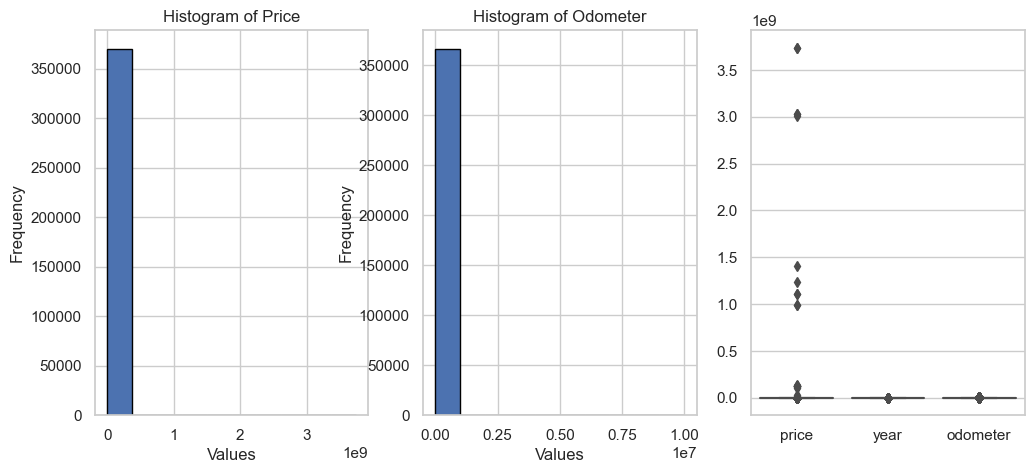

In [215]:
carsOriginal = cars # Just assigning to a new variable so that cleaned data doesn't affect these graphs later on.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
carsOriginal['price'].hist(ax=axes[0], bins=10, edgecolor='black')
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
carsOriginal['odometer'].hist(ax=axes[1], bins=10, edgecolor='black')
axes[1].set_title('Histogram of Odometer')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
sns.boxplot(data=cars)

The histograms definitely show that there are lot of outliers in price and odometer. Since these two are the only non- categorical features, we care about outliers in only these two columns. The next step eliminates the outliers from those two features. 

In [216]:
def eliminateoutliers(col, dataset):
    df=dataset[[col]]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the IQR for each column
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detect outliers using IQR for each column
    outliers_iqr = ((df < lower_bound) | (df > upper_bound)).any(axis=1)
    return dataset[~outliers_iqr]

In [217]:
print("Total cars before outlier removal:", len(cars))
cars = eliminateoutliers('price', cars)
print("Total cars after removing price outliers", len(cars))
cars = eliminateoutliers('odometer', cars)
print("Total cars after removing odometer outliers", len(cars))

Total cars before outlier removal: 370389
Total cars after removing price outliers 363566
Total cars after removing odometer outliers 359878


Text(0.5, 1.0, 'Odometer Histogram')

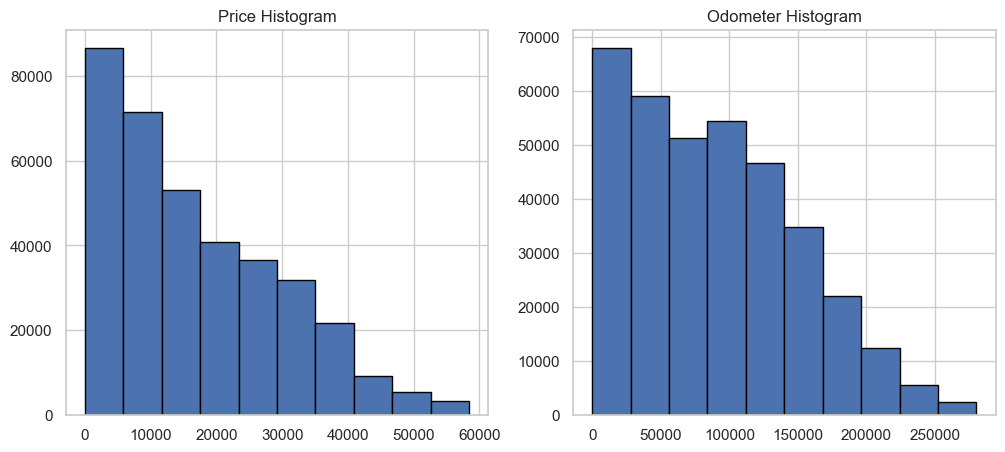

In [218]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
cars['price'].hist(ax=axes[0], bins=10, edgecolor='black')
cars['odometer'].hist(ax=axes[1], bins=10, edgecolor='black')
axes[0].set_title('Price Histogram')
axes[1].set_title('Odometer Histogram')

After removing outliers the data seems little bit evenly distributed.

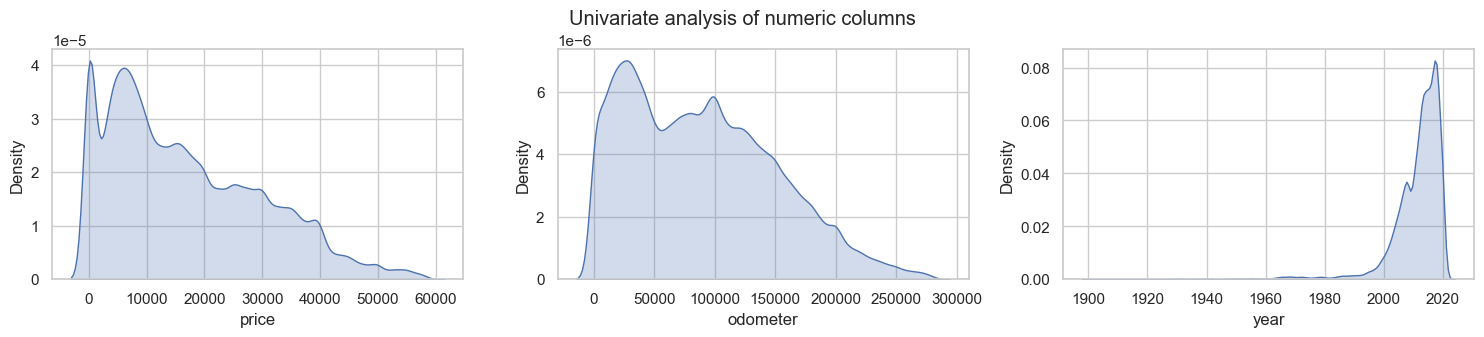

In [219]:
numericCols = ['price', 'odometer', 'year']
plt.figure(figsize=(15, 15))
plt.suptitle("Univariate analysis of numeric columns")
for col in range(len(numericCols)):
    plt.subplot(5,3,col+1)
    sns.kdeplot(x = cars[numericCols[col]], shade=True)
    plt.xlabel(numericCols[col])
    plt.tight_layout()

#### Observations after outlier removal

After eliminating the outliers from the dataset, there is a significant difference in the histograms of price and odometers and the KDE plots also show that the data is somewhat evenly distributed compared to before removing outlers.

### Null Handling

We noticed before that there are some columns with very few nulls. we are dropping those columns altogether. But for other columns where we have significant nulls, we can replace them with most frequently occurring value. 

In [220]:
cars.isnull().sum()

region               0
price                0
year               827
manufacturer     13653
model             4246
condition       135539
cylinders       145965
fuel              2393
odometer          3370
title_status      6541
transmission      1971
drive           109317
type             75719
paint_color     105232
state                0
dtype: int64

In [221]:
# for Odometer, we can take mean of odometer values to fill in the null value. 
cars['odometer'].fillna(math.ceil(np.mean(cars['odometer'])), inplace=True)

For other categoricla values, replacing the null values with most occurance value, two ways we can handle these:
1. Imputing
2. Replace a common value


Currently using the method of replacing the values using the most occurance value of that column, this might impact the performance of the model. Will evaluate and see and when improving the model perofmance will consider other options.


In [222]:
cars['condition'].fillna("good", inplace=True)
cars['manufacturer'].fillna('ford', inplace=True)
cars['cylinders'].fillna('6 cylinders', inplace=True)
cars['fuel'].fillna('gas', inplace=True)
cars['title_status'].fillna('clean', inplace=True)
cars['drive'].fillna('4wd', inplace=True)
cars['type'].fillna('sedan', inplace=True)
cars['paint_color'].fillna('white', inplace=True)
cars['transmission'].fillna('other',inplace=True)
cars['year'].fillna(2014,inplace=True)
cars['model'].fillna('accord',inplace=True)
cars[:1]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,prescott,6000,2014.0,ford,accord,good,6 cylinders,gas,89723.0,clean,other,4wd,sedan,white,az


In [223]:
cars.isnull().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

**Null Handling Observation**
After removing the null values, it can be seen above that there are no more null values in the total data set, and also we don't have a significant loss of data as we imputed some columns with some other data. 

**More Graphs for observing correlations**
1. Price Vs Condition
2. Price Vs Year
3. Price Vs Cylinders 

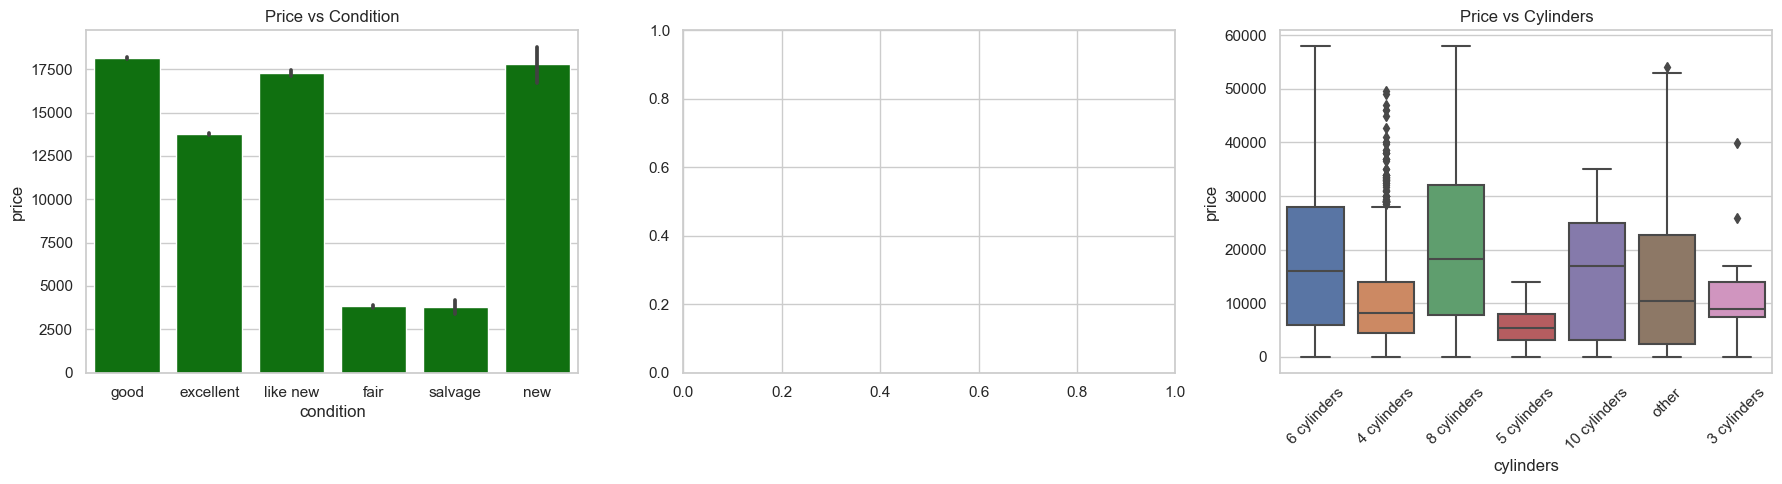

In [224]:
df_sorted = cars.sort_values(by='price')
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=df_sorted['condition'], y=df_sorted['price'], data=df_sorted.sample(10000), ax=axes[0], color='green')
axes[0].set_title('Price vs Condition')
# sns.scatterplot(x='year', y='price', data=cars.sample(10000), ax=axes[1], color='blue')
# axes[1].set_title('Price vs Year')
sns.boxplot(x='cylinders', y='price', data=cars.sample(10000), ax=axes[2])
axes[2].set_title('Price vs Cylinders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations from above graph**

When taken a sample size of 10000, we can observe that the price of car is somewhat correlatable to condition and year i.e. newer vehicles, like new vehiles and good conditioned vehicles are higher priced than fair and salvage vehicles as expected. 

### Reformatted Data
**Convert Non-numeric data to numeric data using Label Encoding**
Non-numeric data such as cylinders, region, manufacturer, model etc. cannot be used to find correlation or to plot pair plots. Hence, we need to convert the data into numeric data. Two ways of doing that are using: 
1. Label Encoding
2. One Hot Encoding

I chose Label Encoding because one hot encoding creates a lot more features to work with. Owing to the size of data and systems we are using, Label encoding is my preferred way. 

In [225]:
# using LabelEncoder converting categorical features into numbers
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
cars_processed = cars.apply(labelEncoder.fit_transform)

In [226]:
cars_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359878 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   region        359878 non-null  int64
 1   price         359878 non-null  int64
 2   year          359878 non-null  int64
 3   manufacturer  359878 non-null  int64
 4   model         359878 non-null  int64
 5   condition     359878 non-null  int64
 6   cylinders     359878 non-null  int64
 7   fuel          359878 non-null  int64
 8   odometer      359878 non-null  int64
 9   title_status  359878 non-null  int64
 10  transmission  359878 non-null  int64
 11  drive         359878 non-null  int64
 12  type          359878 non-null  int64
 13  paint_color   359878 non-null  int64
 14  state         359878 non-null  int64
dtypes: int64(15)
memory usage: 43.9 MB


In [227]:
cars_processed.sample(15)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
289398,59,10575,107,7,13418,2,5,2,8928,0,0,2,9,10,35
317034,100,2288,86,13,17274,2,5,0,99927,0,0,0,9,10,37
44698,263,6750,105,31,19783,2,3,2,22669,0,0,1,7,3,4
273139,196,0,106,31,7580,0,5,2,33626,0,0,0,9,9,34
426843,397,8142,105,13,1735,2,5,2,27592,0,0,0,9,10,50
272708,196,0,107,13,13844,0,5,2,12005,0,0,0,8,10,34
205586,183,3169,93,39,24224,0,5,2,52934,0,0,1,2,0,22
21278,19,0,106,16,10087,2,5,2,41051,0,0,1,9,10,4
341060,399,1202,99,13,15758,2,3,2,95272,0,0,1,9,1,38
213947,217,0,106,7,12664,2,5,2,49156,0,0,0,9,10,23


In [228]:
cars.to_csv("vehicles_processed.csv")

**Encoding Notes**
After using Label Encoding from SK Learn, we could see that all the above data is now transformed into numeric data. 

#### Correlation Matrix and Heat maps


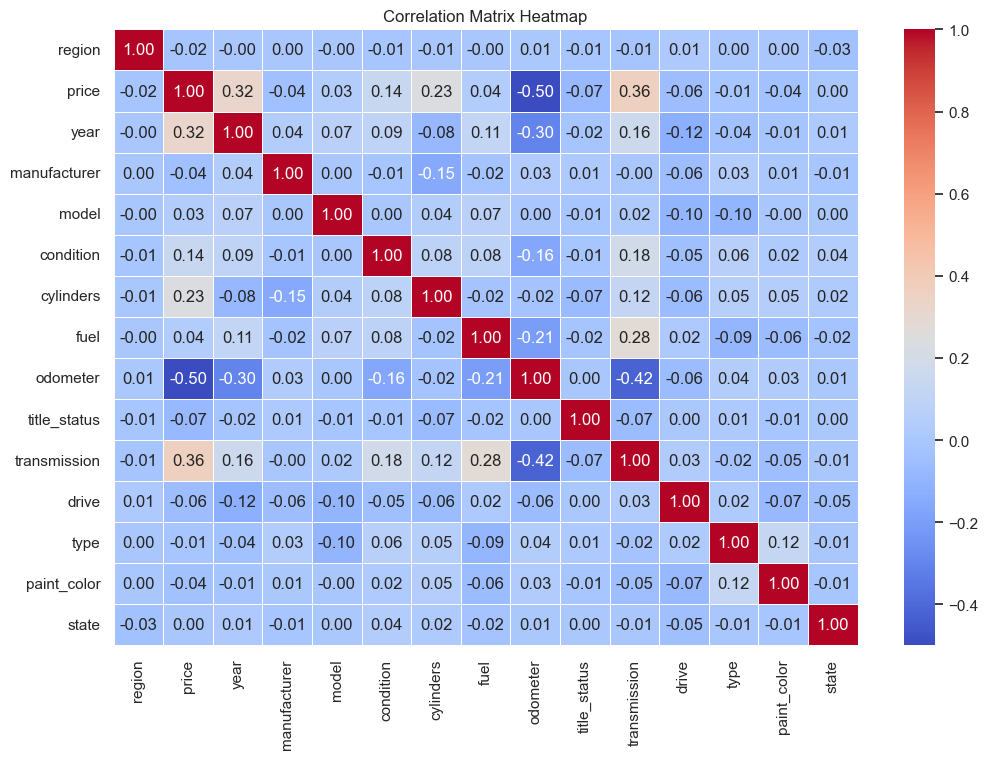

In [229]:
correlation_matrix = cars_processed.corr()
plt.figure(figsize=(12, 8))
sns.color_palette("tab10")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Correlation Matrix Notes:**
From the above matrix, we can observe that the odometer, transmission and year have higher correlation to price compared to other features as expected. 

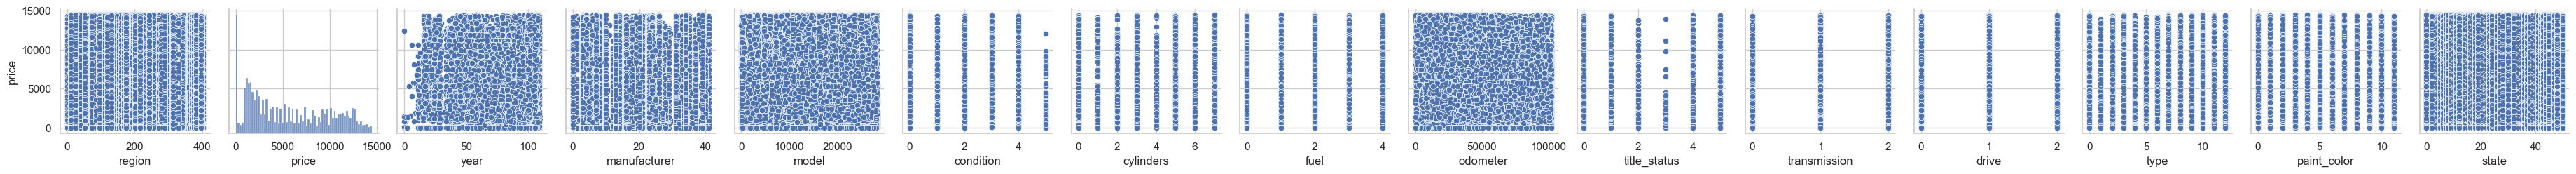

In [230]:
sns.pairplot(data=cars_processed,y_vars='price', x_vars=cars_processed.columns)

The above pairpolt tells the correlation between price and all other features in the dataset.

## Modeling

Now we have cleaned dataset, lets build some models and see how these performs on the dataset with various modeling techniques.

In [231]:
# creating this dictionary to track the performance of each model. This can be used at the end to evaluate/describe each model performance.
train_performance={}
test_performance={}

In [232]:
# create dependenant and independant features set
X = cars_processed.drop('price', axis=1) # dropping price since that is our target.
y = cars_processed['price'] # Setting prices as target.

#split the original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Linear Regression

Lets build a standard linear regression model, understnad the performance and see for improvements.

In [233]:
# Build a standard linear regression and evaluate the performance of it
linearRegression = LinearRegression().fit(X_train, y_train)

lr_score = linearRegression.score(X_train, y_train) # this is the base performance of the existing data set.
lr_r2_score = r2_score(y_test,linearRegression.predict(X_test))
train_performance['LR'] = lr_score
test_performance['LR'] = lr_r2_score

print(train_performance,test_performance)
 

{'LR': 0.37509858156620846} {'LR': 0.370834715375883}


This is the base performance of the linear regression model without any fine tuning on the data.

### Scaling

Applying StandardScaler on the dataset to standardize the data

In [234]:
# using StandardScaler and scale the X_train split
stdScalar = StandardScaler().fit(X_train)
X_train_scaled = stdScalar.transform(X_train)

### PCA Analysis
PCA Analysis with 2 components to see how the model performance

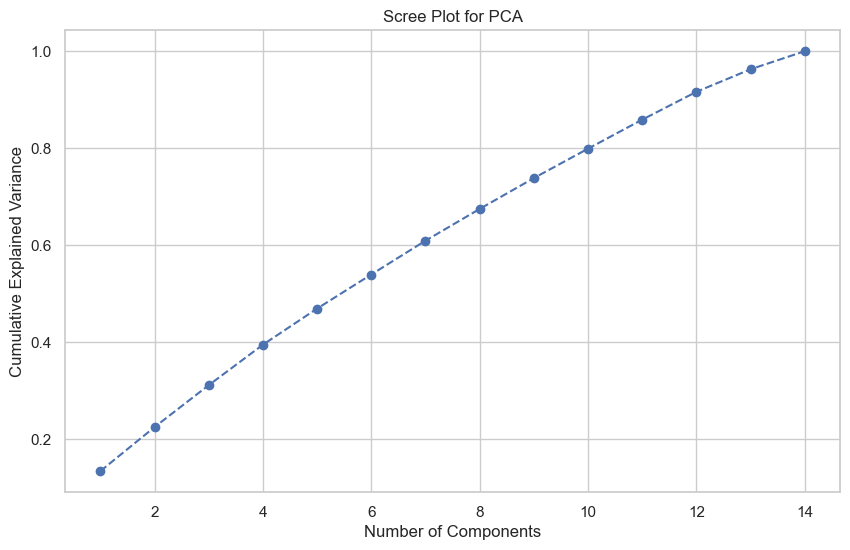

In [235]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, X.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Scree Plot for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Exaplained variance crossed 80 at 10 components so 10 components would be good idea to proceed with model building.

In [236]:
pca = PCA(n_components=10).fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

In [237]:
# Helper method to transform the X_train using StandardScaler and PCA
def getTransformedXTest():
    X_test_scaled = stdScalar.transform(X_test)
    x_transformed = pca.transform(X_test_scaled)
    return x_transformed

In [238]:
# Build a linear regression on the PCA data
linReg = LinearRegression().fit(X_pca, y_train)
lrpcaScore = linReg.score(X_pca, y_train)
train_performance["LRPCA"]= lrpcaScore
test_performance['LRPCA'] = r2_score(y_test,linReg.predict(getTransformedXTest()))

print(test_performance,train_performance)

{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273} {'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205}


Here we see some improvements of Linear Regression model with PCA data.

In [239]:
# Pipeine for Linear Regression and fit the scaled data
pipe = Pipeline([
    ('pca', PCA()),
    ('linearRegression', LinearRegression())
])
params = {
    'pca__n_components' : [5,10,15,20]    
}

grid = GridSearchCV(pipe, param_grid=params).fit(X_train_scaled,y_train)
print(grid.best_estimator_)
print(grid.best_score_)


Pipeline(steps=[('pca', PCA(n_components=10)),
                ('linearRegression', LinearRegression())])
0.32860412410091533


With PCA with 10 componenets and GridSeach the model performed close to **75%** accuracy which is a significant boost compared to standard model.

### K-Means
Lets evaluate the performance using kMeans.

In [240]:
# Kmeans on PCA scaled Data.
pipe = Pipeline([
    ('kmeans', KMeans()),
    ('linearRegression', LinearRegression())
])
params = {
    'kmeans__n_clusters' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
grid = GridSearchCV(pipe, param_grid=params).fit(X_pca, y_train)
print(grid.best_estimator_)

# predict the performance using GridSearch
train_performance['KM_GS_LR'] = grid.best_score_
test_performance['KM_GS_LR'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)


Pipeline(steps=[('kmeans', KMeans(n_clusters=9)),
                ('linearRegression', LinearRegression())])
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701}


In [241]:
# KMeans on actual data
pipe = Pipeline([
    ('kmeans', KMeans()),
    ('linearRegression', LinearRegression())
])
params = {
    'kmeans__n_clusters' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
grid = GridSearchCV(pipe, param_grid=params).fit(X_train, y_train)
print(grid.best_estimator_)

# predict the performance using GridSearch
train_performance['KM_ORG_GS_LR'] = grid.best_score_
test_performance['KM_ORG_GS_LR'] = r2_score(y_test,grid.predict(X_test))
print(train_performance)
print(test_performance)


Pipeline(steps=[('kmeans', KMeans(n_clusters=10)),
                ('linearRegression', LinearRegression())])
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415}


The above two models with X_train and X_pca to see how it impacts the performance of these models. We see improvements of K-Means with PCA data.

### Ridge Regression
Lets evaluate the performance of the Ridge model 

In [242]:
# Ridge Regression on PCA Data
pipeRidge = Pipeline([
    ('ridge', Ridge())
])
params_dict = {'ridge__alpha': [0.1, 1.0, 10.0]}
grid = GridSearchCV(pipeRidge, param_grid=params_dict)
grid.fit(X_pca, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
# predict the performance using GridSearch
train_performance['RIDGE_GS_LR'] = grid.best_score_
test_performance['RIDGE_GS_LR'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)

Pipeline(steps=[('ridge', Ridge(alpha=10.0))])
0.32836092989950727
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516, 'RIDGE_GS_LR': 0.32836092989950727}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415, 'RIDGE_GS_LR': 0.32480349854679835}


In [243]:
# Ridge Regression on PCA Data with KMeans
pipeRidge = Pipeline([
    ('kmeans', KMeans()),
    ('ridge', Ridge())
])
params_dict = {
    'ridge__alpha': [0.1, 1.0, 10.0],
    'kmeans__n_clusters' : [2,4,6,8,10]
}
grid = GridSearchCV(pipeRidge, param_grid=params_dict)
grid.fit(X_pca, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
# predict the performance using GridSearch
train_performance['KM_RIDGE_GS_LR'] = grid.best_score_
test_performance['KM_RIDGE_GS_LR'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)

Pipeline(steps=[('kmeans', KMeans(n_clusters=10)), ('ridge', Ridge())])
0.3969798663013405
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516, 'RIDGE_GS_LR': 0.32836092989950727, 'KM_RIDGE_GS_LR': 0.3969798663013405}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415, 'RIDGE_GS_LR': 0.32480349854679835, 'KM_RIDGE_GS_LR': 0.39171940654896564}


### Sequential Feature Selection

In [244]:
# Sequential feature selection on Original data.
pipeSeq = Pipeline([
    ('seq', SequentialFeatureSelector(estimator=Ridge())), 
    ('linreg', LinearRegression())
])

params_dict = {
    'seq__n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
grid = GridSearchCV(pipeSeq, param_grid=params_dict)
grid.fit(X_pca, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
# predict the performance using GridSearch
train_performance['SFS_GS_LR'] = grid.best_score_
test_performance['SFS_GS_LR'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)

Pipeline(steps=[('seq',
                 SequentialFeatureSelector(estimator=Ridge(),
                                           n_features_to_select=9)),
                ('linreg', LinearRegression())])
0.3283551333988197
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516, 'RIDGE_GS_LR': 0.32836092989950727, 'KM_RIDGE_GS_LR': 0.3969798663013405, 'SFS_GS_LR': 0.3283551333988197}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415, 'RIDGE_GS_LR': 0.32480349854679835, 'KM_RIDGE_GS_LR': 0.39171940654896564, 'SFS_GS_LR': 0.3247932613690875}


In [245]:
# Sequential feature selection on PCA data.
pipeSeq = Pipeline([
    ('seq', SequentialFeatureSelector(estimator=Ridge())),
    ('linreg', LinearRegression())
])

params_dict = {
    'seq__n_features_to_select': [5,10,15,20],
}
grid = GridSearchCV(pipeSeq, param_grid=params_dict)
grid.fit(X_pca, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
# predict the performance using GridSearch
train_performance['SFS_RIDGE_GS_LR'] = grid.best_score_
test_performance['SFS_RIDGE_GS_LR'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)

Pipeline(steps=[('seq',
                 SequentialFeatureSelector(estimator=Ridge(),
                                           n_features_to_select=5)),
                ('linreg', LinearRegression())])
0.32613536600615767
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516, 'RIDGE_GS_LR': 0.32836092989950727, 'KM_RIDGE_GS_LR': 0.3969798663013405, 'SFS_GS_LR': 0.3283551333988197, 'SFS_RIDGE_GS_LR': 0.32613536600615767}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415, 'RIDGE_GS_LR': 0.32480349854679835, 'KM_RIDGE_GS_LR': 0.39171940654896564, 'SFS_GS_LR': 0.3247932613690875, 'SFS_RIDGE_GS_LR': 0.322447713633905}


Above two models with Sequential Feature Selections using Ridge as regressor when selecting features.

**Polynomial Feature Selection**


In [246]:
# Polynomial feature selection on PCA data.
pipeSeq = Pipeline([
    ('pFeat', PolynomialFeatures()),
    ('linreg', LinearRegression())
])

params_dict = {
    'pFeat__degree':[2]
}
grid = GridSearchCV(pipeSeq, param_grid=params_dict)
grid.fit(X_pca, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
# predict the performance using GridSearch
train_performance['POLY_GS_LR'] = grid.best_score_
test_performance['POLY_GS_LR'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)

Pipeline(steps=[('pFeat', PolynomialFeatures()),
                ('linreg', LinearRegression())])
0.4282865687350258
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516, 'RIDGE_GS_LR': 0.32836092989950727, 'KM_RIDGE_GS_LR': 0.3969798663013405, 'SFS_GS_LR': 0.3283551333988197, 'SFS_RIDGE_GS_LR': 0.32613536600615767, 'POLY_GS_LR': 0.4282865687350258}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415, 'RIDGE_GS_LR': 0.32480349854679835, 'KM_RIDGE_GS_LR': 0.39171940654896564, 'SFS_GS_LR': 0.3247932613690875, 'SFS_RIDGE_GS_LR': 0.322447713633905, 'POLY_GS_LR': 0.42317412974130886}


We see  a lof of improvement with Ploynomial Feature Selection  along with Linear Regression.

### BayesianRidge Regression

In [247]:
# Polynomial feature selection with LogisticRegression
from sklearn.linear_model import BayesianRidge
pipeSeq = Pipeline([
    ('pFeat', PolynomialFeatures()),
    ('bReg', BayesianRidge())
])

params_dict = {
    'pFeat__degree':[2]
}
grid = GridSearchCV(pipeSeq, param_grid=params_dict)
grid.fit(X_pca, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
# predict the performance using GridSearch
train_performance['POLY_BRIDGE_GS_LASSO'] = grid.best_score_
test_performance['POLY_BRIDGE_GS_LASSO'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)

Pipeline(steps=[('pFeat', PolynomialFeatures()), ('bReg', BayesianRidge())])
0.4282864520606607
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516, 'RIDGE_GS_LR': 0.32836092989950727, 'KM_RIDGE_GS_LR': 0.3969798663013405, 'SFS_GS_LR': 0.3283551333988197, 'SFS_RIDGE_GS_LR': 0.32613536600615767, 'POLY_GS_LR': 0.4282865687350258, 'POLY_BRIDGE_GS_LASSO': 0.4282864520606607}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415, 'RIDGE_GS_LR': 0.32480349854679835, 'KM_RIDGE_GS_LR': 0.39171940654896564, 'SFS_GS_LR': 0.3247932613690875, 'SFS_RIDGE_GS_LR': 0.322447713633905, 'POLY_GS_LR': 0.42317412974130886, 'POLY_BRIDGE_GS_LASSO': 0.42317742368549793}


### ElasticNet Regression

In [248]:
# Polynomial feature selection with ElasticNet
from sklearn.linear_model import ElasticNet
pipeSeq = Pipeline([
    ('pFeat', PolynomialFeatures()),
    ('mtReg', ElasticNet())
])

params_dict = {
    'pFeat__degree':[2],
    'mtReg__alpha': [0.1, 1.0, 10.0]
}
grid = GridSearchCV(pipeSeq, param_grid=params_dict)
grid.fit(X_pca, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
# predict the performance using GridSearch
train_performance['POLY_ELASTIC_GS_LASSO'] = grid.best_score_
test_performance['POLY_ELASTIC_GS_LASSO'] = r2_score(y_test,grid.predict(getTransformedXTest()))
print(train_performance)
print(test_performance)

Pipeline(steps=[('pFeat', PolynomialFeatures()),
                ('mtReg', ElasticNet(alpha=0.1))])
0.42544534319335325
{'LR': 0.37509858156620846, 'LRPCA': 0.32845404565553205, 'KM_GS_LR': 0.3982488920949113, 'KM_ORG_GS_LR': 0.26484426788352516, 'RIDGE_GS_LR': 0.32836092989950727, 'KM_RIDGE_GS_LR': 0.3969798663013405, 'SFS_GS_LR': 0.3283551333988197, 'SFS_RIDGE_GS_LR': 0.32613536600615767, 'POLY_GS_LR': 0.4282865687350258, 'POLY_BRIDGE_GS_LASSO': 0.4282864520606607, 'POLY_ELASTIC_GS_LASSO': 0.42544534319335325}
{'LR': 0.370834715375883, 'LRPCA': 0.32480338334759273, 'KM_GS_LR': 0.3826438484006701, 'KM_ORG_GS_LR': 0.26267281061040415, 'RIDGE_GS_LR': 0.32480349854679835, 'KM_RIDGE_GS_LR': 0.39171940654896564, 'SFS_GS_LR': 0.3247932613690875, 'SFS_RIDGE_GS_LR': 0.322447713633905, 'POLY_GS_LR': 0.42317412974130886, 'POLY_BRIDGE_GS_LASSO': 0.42317742368549793, 'POLY_ELASTIC_GS_LASSO': 0.4206126308811863}


### Cross-Validation
Lets do cross validation of the best model

In [249]:
cv = KFold(n_splits=10)
scores = cross_val_score(grid,X_pca,y_train,cv=cv)
print(scores)

[0.42568341 0.42963682 0.42167238 0.42980812 0.42542843 0.42359474
 0.42540908 0.42588156 0.42093992 0.42673008]


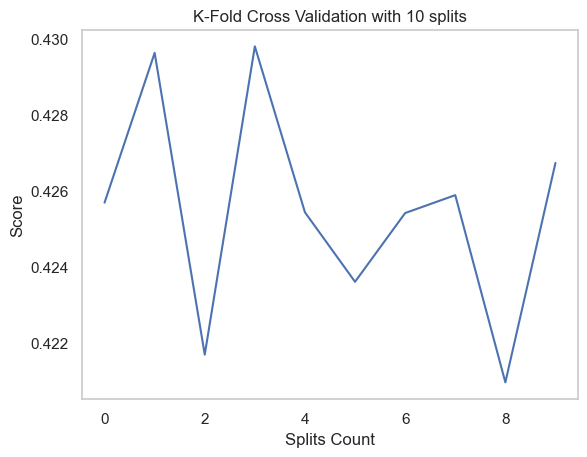

In [250]:
plt.plot(scores)
plt.title('K-Fold Cross Validation with 10 splits')
plt.xlabel('Splits Count')
plt.ylabel('Score')
plt.grid()

The above plot tells that the model trained with various splits on the train data and the performance of it.

## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Evaluate Results

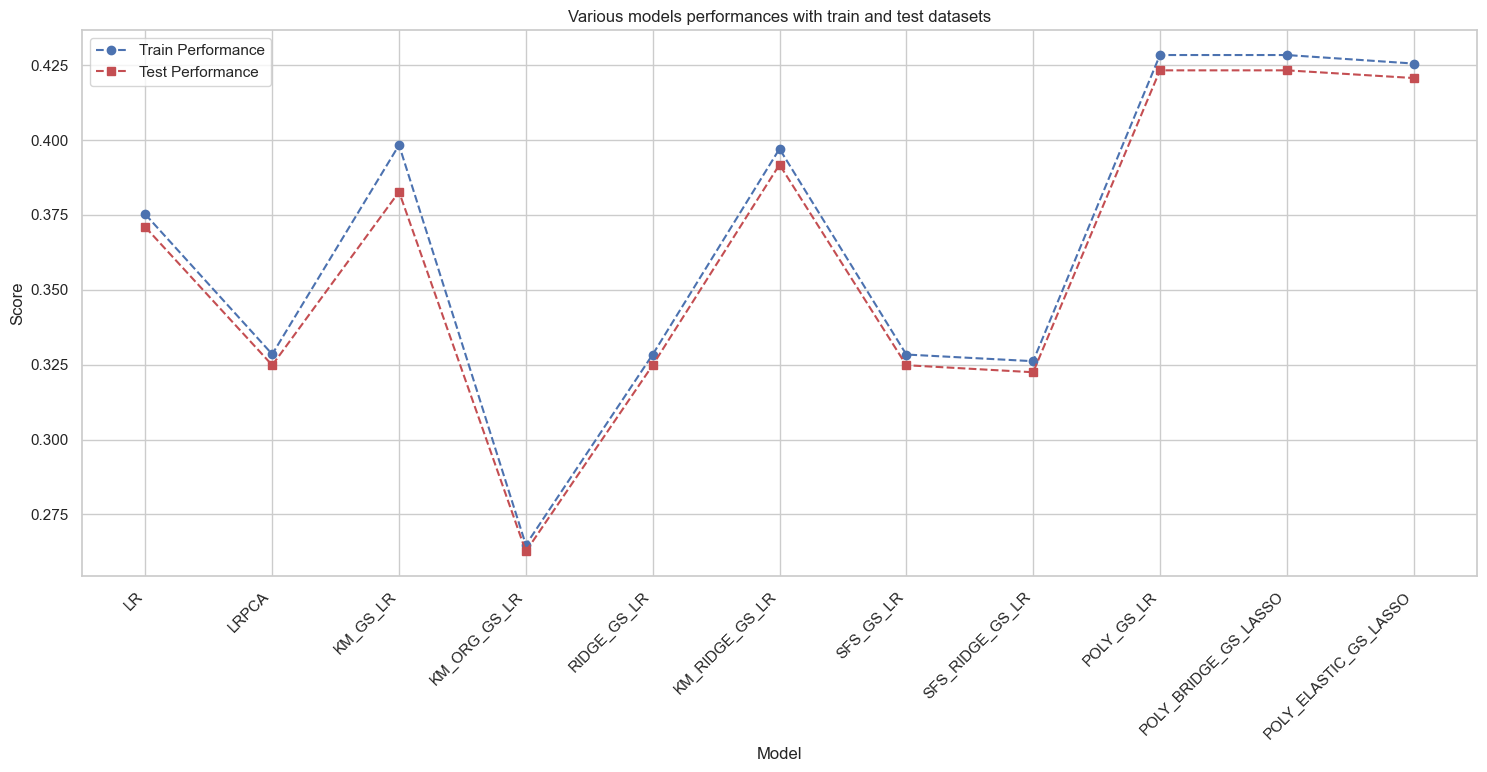

In [251]:
fig = plt.figure(figsize=(18,7))
plt.title("Various models performances with train and test datasets")
plt.plot(train_performance.keys(), train_performance.values(),label="Train Performance",linestyle='--', marker='o', color='b')
plt.plot(test_performance.keys(),test_performance.values(),label="Test Performance",linestyle='--', marker='s', color='r')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.xlabel("Model")
plt.ylabel("Score")
spacing = 0.100
fig.subplots_adjust(bottom=spacing)
plt.show()

The above plot shows the performance with various models trained and tested so far. This graph tells that Polynomial Featiure Selection with Linear Regression and Lasso and ElastiNet models performed very well than others

### Review Process

Here are the findings from above models and all.
1. There are many rows with target price as 0 values which needs to be fixed somehow.
2. Probably need to evaluate some more linear models and other regression models in classification catgory to see how they perform as well.

### Nest Steps

The next steps are evaluate some more on the data and make improvements to the dataset to make sure they are very accurate.

Here are few things to consider:
1. Deploy the best model into an environment where business users can evaluate
2. Make this model to do real-time traning as well so that it can consider future dataset and train and improve the performance even more.

## Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Lets save the model artifacts so that we can deploy this model and will help dealers to fine tune their pricing of the cars.

### Lets build a pipelie

Lets build a pipeline with all the data procesing and the best model so that this can be saved as a joblib file and can be deployed and can be used by end users.

In [252]:
import joblib

Below code block builds a pipeline with all the steps invlolved in this model

In [253]:
# Create end to end pipeline for the car prediction use case
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from category_encoders.target_encoder import TargetEncoder

X = cars.drop('price', axis=1) # dropping price since that is our target.
y = cars['price'] # Setting prices as target.

#remove 0 value price rows
zeroPriceIndexes = cars[(cars['price'] == 0)].index
cars.drop(zeroPriceIndexes , inplace=True)
cat_features = list(cars.select_dtypes(['object']).columns)


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)


# column transfomer for categorical values
categorical_transformer = Pipeline(
    steps=[
        ("encoder", TargetEncoder()),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(transformers=[
    ('pipe',categorical_transformer,cat_features)
])

car_prediction_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components=5)), # 10 components yeilded better results
    ('poly' , PolynomialFeatures(degree=2)), # degree of 2 gives better performance
    ('linearReg', LinearRegression()) # Linear Regression with poly nomial features performed very well compared to other models
]).fit(X_train,y_train)
print(car_prediction_pipeline.score(X_test,y_test))


0.3853151962700826


In [254]:
#  prediction with sample data to make sure it works
print(cars[:1])
print('Value: ',y_test[:1])
sample_df = cars[:1]
sample_df.drop('price',axis=1,inplace=True)
print('Prediction: ',car_prediction_pipeline.predict(sample_df))

     region  price    year manufacturer   model condition    cylinders fuel  \
0  prescott   6000  2014.0         ford  accord      good  6 cylinders  gas   

   odometer title_status transmission drive   type paint_color state  
0   89723.0        clean        other   4wd  sedan       white    az  
Value:  13267    10800
Name: price, dtype: int64
Prediction:  [22379.98496353]


In [255]:
joblib.dump(car_prediction_pipeline,'car_price_prediction_pipeline.joblib')

['car_price_prediction_pipeline.joblib']

### Plan Deployment

Now we have build the model artifacts into joblib file. We can deploy this file along with few APIs using FAST APIs so that this model can be used by business users.

### Test Deployment

Once the model deployed we can ask users to test and evaluate the model with accurate price of the cars sold in a dealership.

### Deploy & Monitor

This model can be deployed into AWS/on-premise servers. This model along with dataset needs to be regualrly  monitored so that we can tune the model and improve the accuracy of the model.